# Practical Implementation of Neural Networks

We define a new objective function as:

$$ J(\mathbf{W})=-[\mathbf{y}^{(i)}\ln\mathbf{a}^{(L)}+(1-\mathbf{y}^{(i)})\ln(1-\mathbf{a}^{(L)}) ]$$

Notice that this is highly similar to the log-likelihood we derived for logistic regression.

Such that the new update for the final layer becomes:

$$ \frac{\partial J(\mathbf{W})}{\mathbf{z}^{(L)}} = ({_i\mathbf{a}^{(L+1)}}- \mathbf{y}^{(i)}) $$

$$ \frac{\partial J(\mathbf{W})}{\mathbf{z}^{(2)}} = ({_i\mathbf{a}^{(3)}}- \mathbf{y}^{(i)})$$

You can verify this via the derivation here: ![CrossEntropyDerivation](PDF_Slides/CrossEntropy.pdf)

Another option is to choose the softmax, which is defined as:

$$  a_j^{(L+1)} = \frac{\exp(z_j^{(L)})}{\sum_i \exp(z_i^{(L)})}  $$

However, it has an identical update equation as the sigmoid final layer using cross entropy. We will stick with cross entropy in order to keep the consistency to previous feedforward code. However, please note that that sigmoid activation functions can suffer more than other activations from gradient instability. 

In [1]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
        sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [2]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    

In [3]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) # <- this is only line that changed
        sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
        
    

In [4]:

# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0
X_test = X_test/255.0


Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [5]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = TLPMiniBatch(**vals)

nn_cross = TLPMiniBatchCrossEntropy(**vals)

%time nn_cross.fit(X_train, y_train, print_progress=1)
%time nn_quad.fit(X_train, y_train, print_progress=1)
print("Done")

Epoch: 20/20

CPU times: user 30.1 s, sys: 10.7 s, total: 40.9 s
Wall time: 28 s


Epoch: 20/20

CPU times: user 29.2 s, sys: 10.4 s, total: 39.6 s
Wall time: 26.5 s
Done


In [6]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Cross Entropy Loss :
Resubstitution acc: 0.928083333333
Validation acc: 0.9259
Quadratic Loss :
Resubstitution acc: 0.892516666667
Validation acc: 0.893


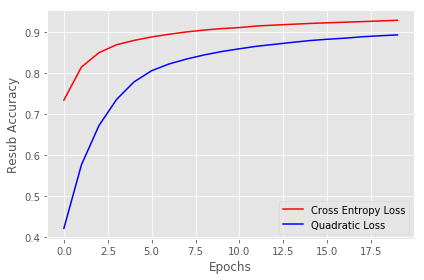

In [7]:
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="Quadratic Loss",color="blue")

plt.show()

## [Back to Slides]

In [8]:

class TLPDropout(TLPMiniBatchCrossEntropy):
    def __init__(self, dropout=True, **kwds):        
        # need to add to the original initializer 
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            
            if self.dropout:
                # be sure to select the other half of the neurons each epoch
                if True :#i%2 == 0:
                    # randomly select half of the neurons
                    idx_dropout = np.random.permutation(W1.shape[0])
                    idx_other_half = idx_dropout[:int(W1.shape[0]/2)]
                    idx_dropout = idx_dropout[int(W1.shape[0]/2):] #drop half
                else:
                    # select the other half
                    idx_dropout = idx_other_half
                    
                idx_dropout = np.sort(idx_dropout)
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                W1 = W1[idx_dropout,:]# get rid of rows
                W2 = W2[:,idx_W2_withbias]# get rid of extra columns
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                
            
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2)
                
                cost = self._cost(A3,Y_enc[:, idx],W1,W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=W1,W2=W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout = delta_W1, delta_W2

            if self.dropout:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                self.W2[:,idx_W2_withbias] = W2
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                delta_W2_prev[:,idx_W2_withbias] = delta_W2_prev_dropout
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

Epoch: 30/30

CPU times: user 45.2 s, sys: 16.5 s, total: 1min 1s
Wall time: 42.7 s


Epoch: 30/30

CPU times: user 40 s, sys: 16.5 s, total: 56.5 s
Wall time: 40.8 s
No Regularization :
Resubstitution acc: 0.920366666667
Validation acc: 0.9181
With Dropout :
Resubstitution acc: 0.897766666667
Validation acc: 0.9002


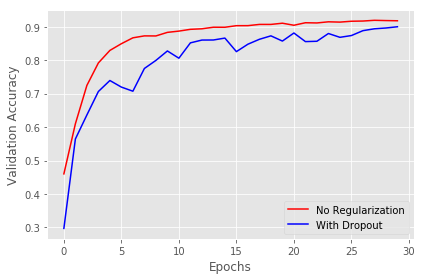

In [9]:
vals = {'n_hidden':30, 
         'C':0.0, 'epochs':30, 'eta':0.001, 
         'alpha':0.0, 'decrease_const':1e-5, 'minibatches':15,
        'shuffle':True,'random_state':1}

# USING NO REGULARIZATION OR DROPOUT OR ANYTHING
nn_noreg = TLPDropout(**vals, dropout=False)

# ADDING ONLY DROPOUT
nn_drop = TLPDropout(**vals, dropout=True)

%time nn_noreg.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))
%time nn_drop.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))

print_result(nn_noreg,X_train,y_train,X_test,y_test,title="No Regularization",color="red")
print_result(nn_drop,X_train,y_train,X_test,y_test,title="With Dropout",color="blue")
plt.show()

The use of dropout typically is only appropriate for much larger networks, with many more hidden layers than what I have provided here. As such, the performance is actually slightly worse (but not terrible).
___

In [10]:
class TLPGaussianInitial(TLPDropout):             
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1 = np.random.randn(self.n_hidden, self.n_features_ + 1)
        W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
        
        W2 = np.random.randn(self.n_output_, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
        return W1, W2

Epoch: 10/10

CPU times: user 14.7 s, sys: 5.09 s, total: 19.8 s
Wall time: 13.3 s


Epoch: 10/10

CPU times: user 14.7 s, sys: 5.06 s, total: 19.8 s
Wall time: 13.1 s
Uniform :
Resubstitution acc: 0.906783333333
Validation acc: 0.9085
Gaussian/$\sqrt{n_i}$ :
Resubstitution acc: 0.931283333333
Validation acc: 0.931


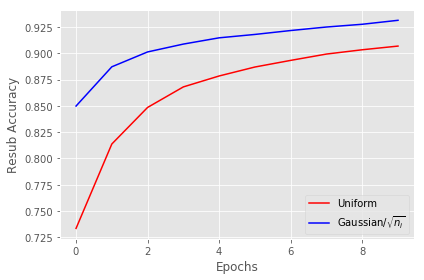

In [12]:
vals = {'n_hidden':30, 
         'C':0.01, 'epochs':10, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_uniform = TLPMiniBatchCrossEntropy(**vals)
nn_gauss = TLPGaussianInitial(**vals, dropout=False)

%time nn_uniform.fit(X_train, y_train, print_progress=1)
%time nn_gauss.fit(X_train, y_train, print_progress=1)

print_result(nn_uniform,X_train,y_train,X_test,y_test,title="Uniform",color="red")
print_result(nn_gauss,X_train,y_train,X_test,y_test,title="Gaussian/$\sqrt{n_i}$",color="blue")
plt.show()

Epoch: 75/75

CPU times: user 2min 41s, sys: 36.1 s, total: 3min 17s
Wall time: 2min 13s
Long Run :
Resubstitution acc: 0.977566666667
Validation acc: 0.9682


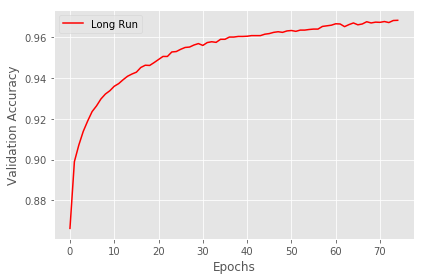

In [69]:
# just for fun, let's look at the output of what happens when we let our system loose
# these values have been hand tuned
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':75, 'eta':0.001, 
         'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
         'shuffle':True,'random_state':1, 'dropout':False}
nn_long_sigmoid = TLPGaussianInitial(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

## [Back To Slides]

# Rectified Linear Units
Now lets look at another type of activation function. The rectified linear unit (ReLu) is an interesting choice to use because of its simplicity. Moreover, we will learn that its backpropagated derivative has some characteristics that are advantageous. 

We define the ReLu neuron as:

$$
    \phi(\mathbf{z}^{(i)})=\left\{
                \begin{array}{ll}
                \mathbf{z}^{(i)}  \text{,  if }\mathbf{z}^{(i)}>0 \\
                \mathbf{0} \text{,      else } \\
                \end{array}
              \right.
$$

Which has a very simple derivative:
$$
    \frac{\partial\phi(\mathbf{z}^{(i)})}{\partial\mathbf{z}^{(i)}}=\left\{
                \begin{array}{ll}
                \mathbf{1} \text{,  if }\mathbf{z}^{(i)}>0 \\
                \mathbf{0} \text{,      else } \\
                \end{array}
              \right.
$$

In [70]:
class TLPReLu(TLPDropout):
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        # Glorot, Xavier, Antoine Bordes, and Yoshua Bengio. 
        #   "Deep Sparse Rectifier Neural Networks."
        init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))

        init_bound = np.sqrt(2. / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        return W1, W2
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
        
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) 
        # sigma3[Z2<=0] = 0 # can change to be relu back prop on this layer too!
        
        sigma2 = (W2.T @ sigma3) 
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        sigma2[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
nn_long_relu = TLPReLu(**vals) # same as previous parameter values
%time nn_long_relu.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))
print(vals)

Epoch: 75/75

CPU times: user 2min 40s, sys: 34.1 s, total: 3min 14s
Wall time: 2min 4s
{'n_hidden': 50, 'shuffle': True, 'minibatches': 200, 'decrease_const': 1e-09, 'alpha': 0.0, 'epochs': 75, 'C': 0.01, 'random_state': 1, 'eta': 0.001, 'dropout': False}


ReLu :
Resubstitution acc: 0.994733333333
Validation acc: 0.9745
Sigmoid :
Resubstitution acc: 0.977566666667
Validation acc: 0.9682


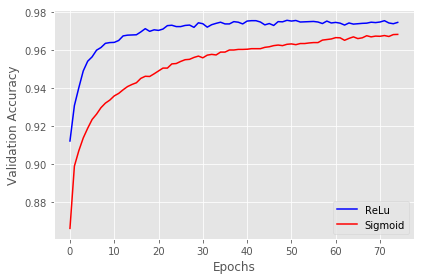

In [71]:
print_result(nn_long_relu, X_train, y_train, X_test, y_test, title="ReLu",color="blue")
print_result(nn_long_sigmoid, X_train, y_train, X_test, y_test, title="Sigmoid",color="red")

# Sklearn Implementation

In [72]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print(sklearn_version)
# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=75, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

0.18.1
CPU times: user 1min 48s, sys: 16.4 s, total: 2min 5s
Wall time: 1min 17s
Validation Acc: 0.9735


/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [73]:
# but with this implementation we can also easily change Neurons
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 'auto', # min of 200, num_samples
                    learning_rate='constant', # adapt learning? only for sgd
                    learning_rate_init=0.1, # only SGD
                    power_t=0.0,    # only SGD with inverse scaling of learning rate
                    max_iter=75, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

CPU times: user 1min 44s, sys: 15.8 s, total: 1min 59s
Wall time: 1min 10s
Validation Acc: 0.972


/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
